In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tqdm
import shutil

In [2]:
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/test1.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [3]:
zip_ref = zipfile.ZipFile("../input/dogs-vs-cats/train.zip", 'r')
zip_ref.extractall("../tmp/dogs-vs-cats")
zip_ref.close()

In [4]:
!ls ../tmp/dogs-vs-cats/

test1  train


In [5]:
base_dir = '../tmp/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
testing_dir = os.path.join(base_dir, 'test1')

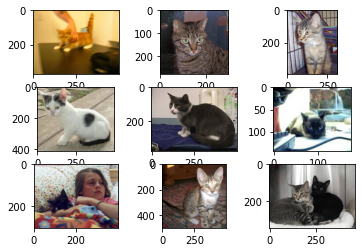

In [6]:
from matplotlib import pyplot
from matplotlib.image import imread
folder = train_dir + '/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

../tmp/dogs-vs-cats/train/dog.0.jpg
../tmp/dogs-vs-cats/train/dog.1.jpg
../tmp/dogs-vs-cats/train/dog.2.jpg
../tmp/dogs-vs-cats/train/dog.3.jpg
../tmp/dogs-vs-cats/train/dog.4.jpg
../tmp/dogs-vs-cats/train/dog.5.jpg
../tmp/dogs-vs-cats/train/dog.6.jpg
../tmp/dogs-vs-cats/train/dog.7.jpg
../tmp/dogs-vs-cats/train/dog.8.jpg


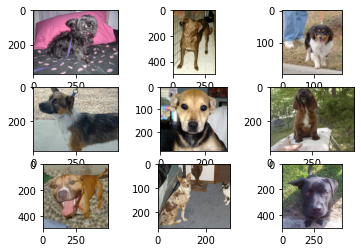

In [7]:
from matplotlib import pyplot
from matplotlib.image import imread
folder = train_dir + '/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    print(filename)
    
    image = imread(filename)
    pyplot.imshow(image)

pyplot.show()

In [8]:
train_file_list = os.listdir('../tmp/dogs-vs-cats/train')
print('Num of images:', len(train_file_list))

dog_filenames = [fn for fn in train_file_list if fn.startswith('dog')]
cat_filenames = [fn for fn in train_file_list if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)


train_dog, valid_dog, train_cat, valid_cat  = [fns for fns in dataset_filenames]


train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

Num of images: 25000
Train: 22500, test: 2500


In [9]:
TRAIN_DIR_DOG = train_dir + '/dog'
TRAIN_DIR_CAT = train_dir + '/cat'

valid_dir = base_dir + '/valid'
VALID_DIR_DOG = valid_dir + '/dog'
VALID_DIR_CAT = valid_dir + '/cat'

In [10]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(train_dir, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

100%|██████████| 11250/11250 [00:01<00:00, 10997.65it/s]


elements in ../tmp/dogs-vs-cats/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 14671.51it/s]


elements in ../tmp/dogs-vs-cats/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 13573.75it/s]


elements in ../tmp/dogs-vs-cats/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 14516.46it/s]

elements in ../tmp/dogs-vs-cats/valid/cat: 1250


In [11]:
!ls ../tmp/dogs-vs-cats/train

cat  dog


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2021-11-23 04:46:39.058765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 04:46:39.174008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 04:46:39.175417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 04:46:39.178132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        batch_size=20,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  
      verbose=1)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


2021-11-23 04:46:43.663754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-23 04:46:45.833404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 17s 97ms/step - loss: 0.6904 - accuracy: 0.5400 - val_loss: 0.6764 - val_accuracy: 0.6040
Epoch 2/50
100/100 [==============================] - 12s 116ms/step - loss: 0.6626 - accuracy: 0.6060 - val_loss: 0.6357 - val_accuracy: 0.6570
Epoch 3/50
100/100 [==============================] - 9s 91ms/step - loss: 0.6296 - accuracy: 0.6400 - val_loss: 0.6017 - val_accuracy: 0.6640
Epoch 4/50
100/100 [==============================] - 9s 90ms/step - loss: 0.6001 - accuracy: 0.6740 - val_loss: 0.5737 - val_accuracy: 0.7090
Epoch 5/50
100/100 [==============================] - 9s 92ms/step - loss: 0.5794 - accuracy: 0.7115 - val_loss: 0.6157 - val_accuracy: 0.6620
Epoch 6/50
100/100 [==============================] - 12s 118ms/step - loss: 0.5694 - accuracy: 0.7100 - val_loss: 0.5725 - val_accuracy: 0.7010
Epoch 7/50
100/100 [==============================] - 9s 90ms/step - loss: 0.5327 - accuracy: 0.7235 - val_loss: 0.5983 - val_accuracy: 0.6780
Epoch

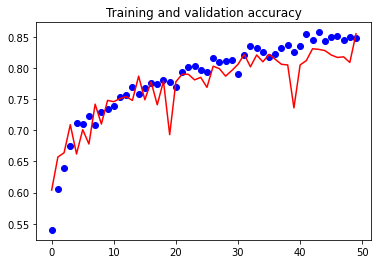

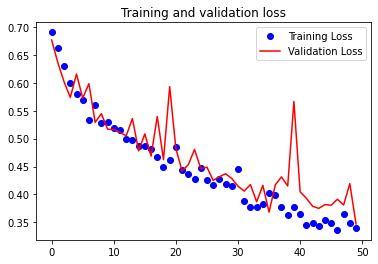

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

(1, 74, 74, 32)
32
(1, 72, 72, 64)
64
(1, 36, 36, 64)
64
(1, 34, 34, 128)
128
(1, 17, 17, 128)
128


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


(1, 15, 15, 128)
128
(1, 7, 7, 128)
128
(1, 6272)
128


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

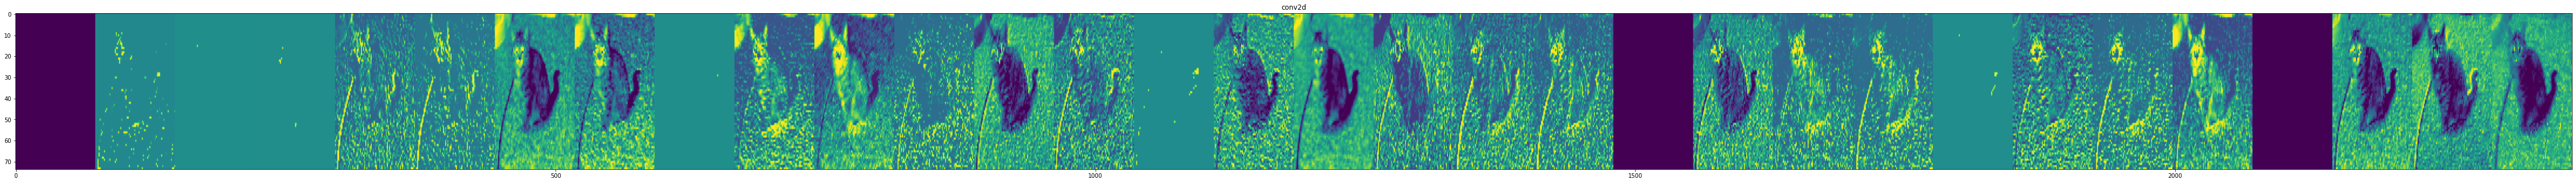

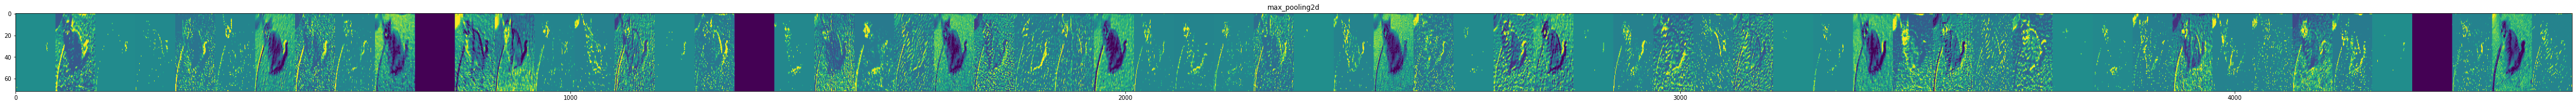

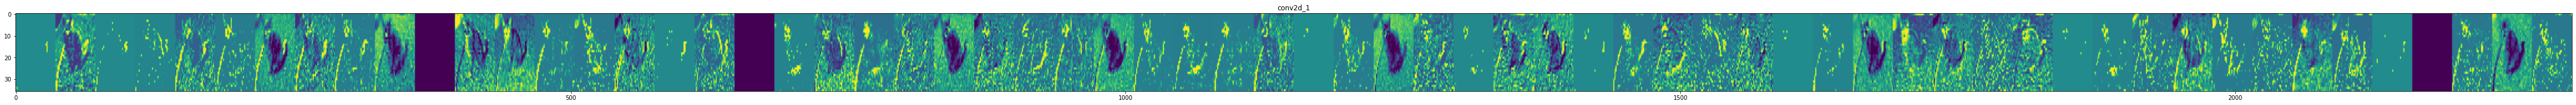

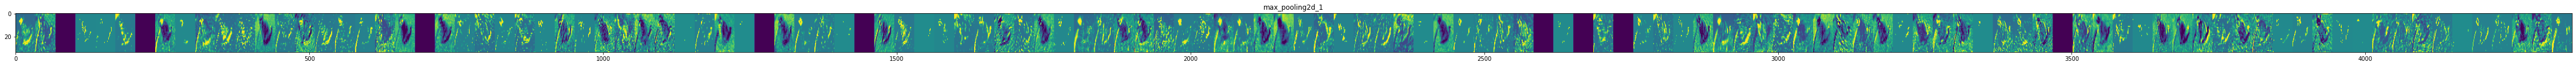

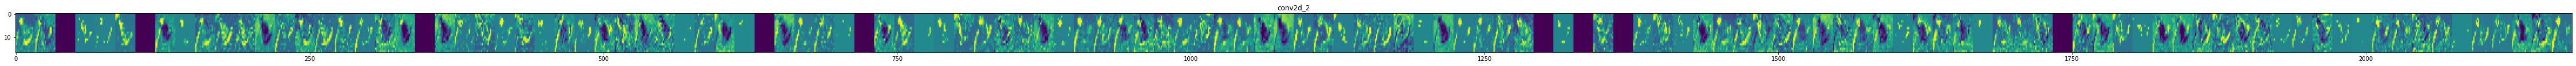

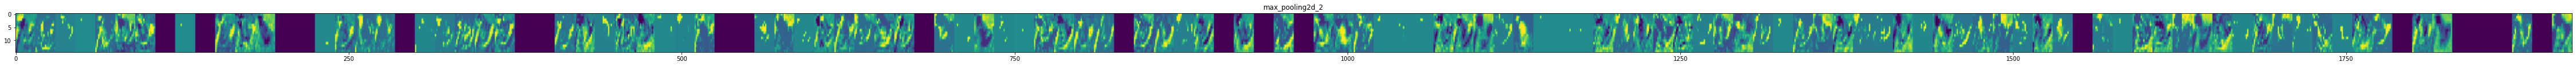

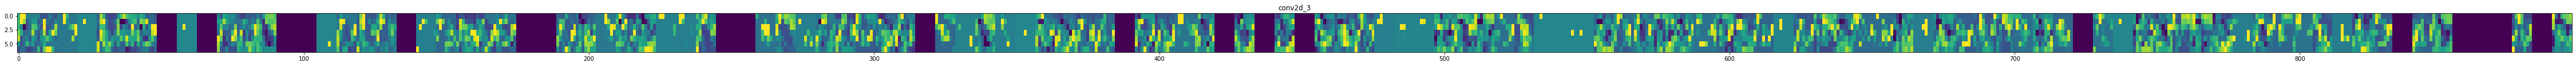

In [16]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img


successive_outputs = [layer.output for layer in model.layers[1:]]


visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


cat_img_files = [os.path.join(TRAIN_DIR_CAT, f) for f in train_cat]
dog_img_files = [os.path.join(TRAIN_DIR_DOG, f) for f in train_dog]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  

x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   

x /= 255.0

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  
    print(n_features)
    size       = feature_map.shape[1]  
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x 
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features * 4, scale * 8) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 